# Download and unzip vehicle dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install kaggle==1.5.6

     |████████████████████████████████| 61kB 3.5MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=25bb761b01fff07de8e9fddfcc4cfc2913a08f9a417f8a8c7c56d9bdfde67d60
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


In [4]:
! cp /content/drive/My\ Drive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                     title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------  -----------------------------------------------  ------  -------------------  -------------  ---------  ---------------  
unanimad/us-election-2020                               US Election 2020                                  429KB  2020-11-15 13:41:13           4323        187  1.0              
manchunhui/us-election-2020-tweets                      US Election 2020 Tweets                           353MB  2020-11-09 18:51:59           2336        146  1.0              
antgoldbloom/covid19-data-from-john-hopkins-university  COVID-19 data from John Hopkins University          2MB  2020-11-16 06:04:17           1519         71  0.9705882        
headsortails/us-election-2020-presidential-debates      US Election 2020 - Presidential Debates           199M

In [5]:
 !mkdir input
 !kaggle competitions download -c vehicle -p input/

100% 6.87G/6.88G [03:16<00:00, 35.7MB/s]
100% 6.88G/6.88G [03:16<00:00, 37.7MB/s]


In [6]:
!unzip input/vehicle.zip -d input/

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: input/train/train/Motorcycle/003967_09.jpg  
  inflating: input/train/train/Motorcycle/003972_10.jpg  
  inflating: input/train/train/Motorcycle/003975_17.jpg  
  inflating: input/train/train/Motorcycle/003977_18.jpg  
  inflating: input/train/train/Motorcycle/003982_17.jpg  
  inflating: input/train/train/Motorcycle/003983_09.jpg  
  inflating: input/train/train/Motorcycle/003989_10.jpg  
  inflating: input/train/train/Motorcycle/003990_01.jpg  
  inflating: input/train/train/Motorcycle/003992_05.jpg  
  inflating: input/train/train/Motorcycle/003992_17.jpg  
  inflating: input/train/train/Motorcycle/003993_09.jpg  
  inflating: input/train/train/Motorcycle/003993_18.jpg  
  inflating: input/train/train/Motorcycle/003997_00.jpg  
  inflating: input/train/train/Motorcycle/003998_02.jpg  
  inflating: input/train/train/Motorcycle/003998_18.jpg  
  inflating: input/train/train/Motorcycle/003999_01.jpg  
  inflating: in

# Import library

In [7]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras import layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import ZeroPadding2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from gc import callbacks

# Define Constants

In [8]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
INPUT_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
TRAIN_DIR = "/content/input/train/train/"
PREDICTION_DIR = "/content/input/test/testset/"
CATEGORIES = os.listdir(TRAIN_DIR)
print(CATEGORIES)

['Cart', 'Barge', 'Car', 'Segway', 'Truck', 'Boat', 'Tank', 'Snowmobile', 'Bicycle', 'Ambulance', 'Taxi', 'Limousine', 'Bus', 'Caterpillar', 'Motorcycle', 'Van', 'Helicopter']


# Dataset infomation

Folder description:

* `train/train` folder contains the training set: a set of images with true labels in the folder names. The the folder contains altogether 28045 files organized in many sub-folders. The sub-folder names are the true classes; i.e., "Boat" sub-folder has all boat images, "Car" sub-folder has all the car images and so on.

* `test/testset` - folder contains the test set: a set of images without labels. The folder contains altogether 7958 files in a single folder. The file name is the id for the solution's first column; i.e., the predicted class for file "000000.jpg" should appear on the first row of your submission.

* `sample_submission.csv` - a sample submission file in the correct format.

In [ ]:
data = []
for category in sorted(os.listdir(TRAIN_DIR)):
    for file in sorted(os.listdir(os.path.join(TRAIN_DIR, category))):
        data.append((category, file))

df = pd.DataFrame(data, columns=['class', 'file_name'])
df.head(10)

In [ ]:
df['class'].value_counts().plot.bar()

In [ ]:
fig = plt.figure(figsize=(25, 16))
for num, category in enumerate(sorted(df['class'].unique())):
    for i, (idx, row) in enumerate(df.loc[df['class'] == category].sample(4).iterrows()):
        ax = fig.add_subplot(17, 4, num * 4 + i + 1, xticks=[], yticks=[])
        im = Image.open(os.path.join(TRAIN_DIR, category, row['file_name']))
        plt.imshow(im)
        ax.set_title(f'Class: {category}')
fig.tight_layout()
plt.show()

# Build model VGG16

![VGG16 structure](https://iq.opengenus.org/content/images/2019/01/vgg_layers.png)

### VGG16

In [ ]:
model = Sequential()

model.add(InputLayer(input_shape=INPUT_SHAPE))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=4096,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation="softmax"))

### Pre-train vgg16 model

In [ ]:
trained = keras.applications.VGG16(
          include_top=False,
          weights='imagenet',
          input_shape=INPUT_SHAPE
)
trained.trainable = False
#for layer in trained.layers[-4:]:
#   layer.trainable = False

model = Sequential()
model.add(trained)
model.add(Flatten())
model.add(Dense(units=4096, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=4096, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=len(CATEGORIES), activation='softmax'))

In [ ]:
# set optimizer, loss,...
op = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=op,
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dropout_4 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_5 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 17)               

# Set data generator

In [26]:
from keras.applications.vgg16 import preprocess_input

batch_size=15
datagen = ImageDataGenerator(
   #rotation_range=25,
   #rescale=1./255,
   #shear_range=0.1,
   #zoom_range=0.2,
   #horizontal_flip=True,
   #width_shift_range=0.1,
   #height_shift_range=0.2,
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    validation_split=0.1
)

train_generator = datagen.flow_from_directory( 
    directory=TRAIN_DIR, 
    target_size=IMAGE_SIZE,
    shuffle=True,
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    directory=TRAIN_DIR, 
    target_size=IMAGE_SIZE,
    shuffle=True,
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation'
)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())

Found 25247 images belonging to 17 classes.
Found 2798 images belonging to 17 classes.


# Training

In [10]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0000025)
#checkpoint_filepath = '/content/drive/My Drive/checkpoint/vehicle-cp-{epoch:04d}.ckpt'
checkpoint_filepath = '/content/drive/My Drive/checkpoint/vehicle_model_{epoch:04d}.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True,
    verbose=1)

callbacks = [earlystop, learning_rate_reduction]

In [18]:
model_path = '/content/drive/My Drive/vehicle_model.h5'

model = keras.models.load_model(model_path)
#model.load_weights('/content/drive/My Drive/vehicle_model.h5')

**Prevent colab from disconnecting**

* copy this code
```
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,2*60000)
```
* F12 --> console
* Paste on the console prompt

In [19]:
history = model.fit_generator(generator=train_generator,
                              validation_data=validation_generator,
                              epochs=5,
                              callbacks=callbacks)

Epoch 1/5
1684/1684 [==============================] - 641s 380ms/step - loss: 0.1759 - accuracy: 0.9734 - val_loss: 1.5765 - val_accuracy: 0.8928
Epoch 2/5
1684/1684 [==============================] - 580s 345ms/step - loss: 0.1757 - accuracy: 0.9739 - val_loss: 1.6618 - val_accuracy: 0.8749
Epoch 3/5
1684/1684 [==============================] - 580s 344ms/step - loss: 0.1959 - accuracy: 0.9741 - val_loss: 1.8132 - val_accuracy: 0.8874
Epoch 4/5
1684/1684 [==============================] - 575s 341ms/step - loss: 0.1826 - accuracy: 0.9753 - val_loss: 1.5224 - val_accuracy: 0.8853
Epoch 5/5
1684/1684 [==============================] - 573s 340ms/step - loss: 0.1909 - accuracy: 0.9745 - val_loss: 1.6391 - val_accuracy: 0.8878


In [17]:
model.save('/content/drive/My Drive/vehicle_model.h5')

# Visualization training history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


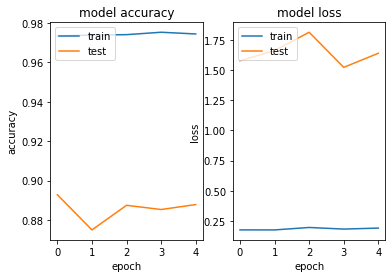

In [20]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
plot_history(history)

# Prediction

Load model

In [21]:
model_path = '/content/drive/My Drive/vehicle_model.h5'
load_model = keras.models.load_model(model_path)

Read and make dataframe for generator

In [22]:
pred_filenames = os.listdir(PREDICTION_DIR)
pred_df = pd.DataFrame({
    'filename': pred_filenames
}).sort_values('filename')
pred_df = pred_df.reset_index(drop=True)
print(pred_df.head(20))

      filename
0   000000.jpg
1   000001.jpg
2   000002.jpg
3   000003.jpg
4   000004.jpg
5   000005.jpg
6   000006.jpg
7   000007.jpg
8   000008.jpg
9   000009.jpg
10  000010.jpg
11  000011.jpg
12  000012.jpg
13  000013.jpg
14  000014.jpg
15  000015.jpg
16  000016.jpg
17  000017.jpg
18  000018.jpg
19  000019.jpg


data generator for prediction

In [23]:
pred_gen = ImageDataGenerator(rescale=1./255)
pred_generator = pred_gen.flow_from_dataframe(
    pred_df, 
    PREDICTION_DIR, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=15,
    shuffle=False
)

Found 7958 validated image filenames.


In [24]:
predict = load_model.predict(pred_generator,
                             verbose=1,
                             batch_size=None)

531/531 [==============================] - 286s 538ms/step


In [27]:
prediction = np.argmax(predict, axis=1)
pred_df['class'] = pd.Series(prediction).apply(lambda x: label_map[x])
print(pred_df)

        filename    class
0     000000.jpg     Boat
1     000001.jpg    Truck
2     000002.jpg      Car
3     000003.jpg      Car
4     000004.jpg  Bicycle
...          ...      ...
7953  007953.jpg    Truck
7954  007954.jpg  Bicycle
7955  007955.jpg      Car
7956  007956.jpg     Boat
7957  007957.jpg     Boat

[7958 rows x 2 columns]


In [28]:
my_df = pd.DataFrame({
    'Id': np.arange(7958)
})
my_df['Category'] = pred_df['class'].copy()
my_df.to_csv('/content/drive/My Drive/my_submission.csv', index=False)

In [ ]:
sample_test = pred_df.sample(18).reset_index(drop=True)
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['class']
    img = load_img(PREDICTION_DIR+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + ' (' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()